## Importamos los datos de ubicación por estación:

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import mean_squared_error
from IPython.display import display, Math, Latex
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

from sklearn.neighbors import KNeighborsRegressor

In [22]:
df_loc_est = pd.read_csv("/Users/danielbustillos/Documents/CONACyT/Marginación_contaminación/datos_estaciones/info_estaciones.csv")

In [23]:
df_loc_est = df_loc_est[["Clave","Longitud","Latitud","Altitud"]]
df_loc_est["Altitud"] = df_loc_est["Altitud"].str[0:5]
df_loc_est = df_loc_est.rename(columns={'Clave': "id_station"})

In [24]:
df_loc_est.head()

,id_station,Longitud,Latitud,Altitud
0,ACO,-98.912003,19.635501,2198
1,AJU,-99.162459,19.154674,2953
2,AJM,-99.207658,19.272100,2619
3,ATI,-99.254133,19.576963,2341
4,BJU,-99.158969,19.371612,2250


### juntamos los dos DF´s:

In [25]:
df_gb = pd.read_csv("./datos_contaminacion_gb.csv")

In [26]:
df_merged = pd.merge(df_loc_est, df_gb, on='id_station')
df_merged.head()

,id_station,Longitud,Latitud,Altitud,anio,CO,NO,NO2,NOX,O3,PM10,PM2.5,PMCO,SO2,TMP,UVA,WSP,dia,hora,mes
0,ACO,-98.912003,19.635501,2198,2013,0.301976,8.037060,13.857365,21.891155,35.748057,41.036889,NaN,NaN,2.740903,17.644663,NaN,2.660823,15.580665,13.636463,6.622785
1,ACO,-98.912003,19.635501,2198,2014,0.284274,8.004613,13.313344,21.307022,33.931571,33.213661,NaN,NaN,2.272389,17.206142,NaN,2.443427,15.548436,13.615526,6.664882
2,ACO,-98.912003,19.635501,2198,2015,0.272488,6.807259,12.366208,19.171965,36.723955,34.134346,NaN,NaN,2.073241,18.170864,NaN,2.647999,15.906907,13.550474,4.511666
3,ACO,-98.912003,19.635501,2198,2016,0.273042,8.157237,14.046196,22.214028,36.199789,36.575620,NaN,NaN,1.962495,18.061013,NaN,2.722300,15.627215,13.588608,7.197046
4,ACO,-98.912003,19.635501,2198,2017,0.349425,9.521148,16.049261,25.569390,33.746395,47.883559,NaN,NaN,2.374241,17.210747,NaN,2.638510,15.634436,13.632909,6.850382


exportamos

In [27]:
df_export = df_merged.groupby("id_station")["Altitud","Longitud","Latitud","PM10","PM2.5"].mean()
df_export.reset_index(inplace=True)
df_export.dropna(inplace=True)

In [28]:
df_export.to_csv("./datos_reales_estaciones_PM25.csv",index=False)

## Filtramos:

In [29]:
df_merged = df_merged[["Longitud","Latitud","Altitud","PM10","O3","PM2.5"]].dropna()

## Entrenamiento:

Parameter:

In [30]:
columnas_ubic = ["Longitud","Latitud"]

In [31]:
features_train, features_test, labels_train, labels_test = train_test_split(df_merged[columnas_ubic], df_merged["PM2.5"], 
                                                                            test_size=0.4, random_state=123)

In [32]:
n = features_train.shape[0]

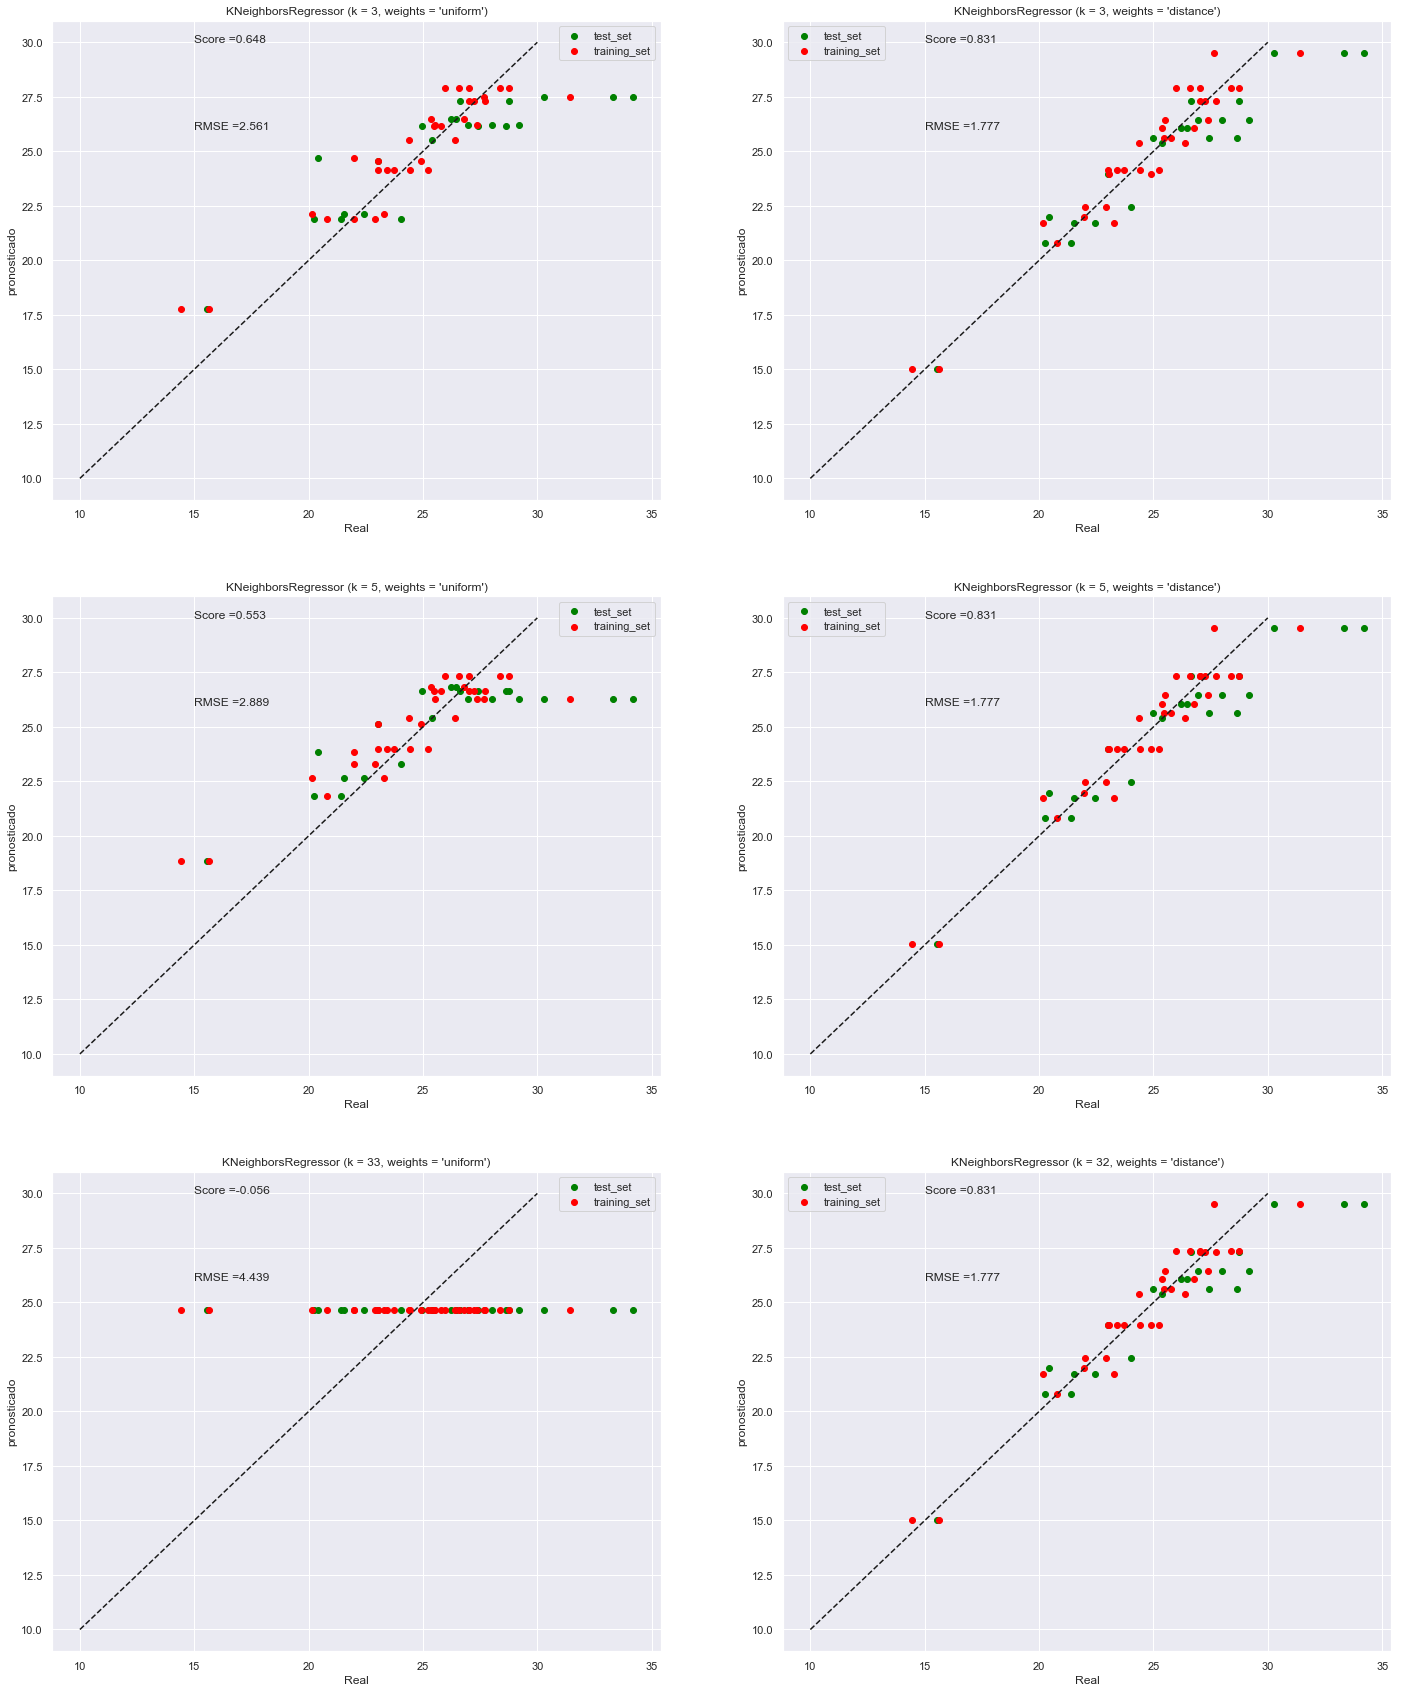

In [33]:
n = features_train.shape[0]
params = [{'weights': 'uniform', 'n_neighbors': 3},
          {'weights': 'distance', 'n_neighbors': 3},
          {'weights': 'uniform', 'n_neighbors': np.sqrt(n).astype(int)},
          {'weights': 'distance', 'n_neighbors': np.sqrt(n).astype(int)},
          {'weights': 'uniform', 'n_neighbors': n},
          {'weights': 'distance', 'n_neighbors': n-1}]

#plot_range = np.arange(features_train.min(), features_train.max(), 0.01)

for i, param in enumerate(params):
    model = KNeighborsRegressor(**params[i])
    model.fit(features_train, labels_train)

    pred = model.predict(features_test)
    # Sort values for plotting
    plt.subplot(3, 2, i + 1)
    plt.scatter(labels_test,pred, c='green', label='test_set')
    plt.scatter(labels_train,model.predict(features_train), c='red', label='training_set')
    
    score = round(model.score(features_test, labels_test),3)
    rmse = round(np.sqrt(mean_squared_error(labels_test, pred)),3)
    
    
    plt.plot([10,30],[10,30],color="k",linestyle='--')
    
    plt.annotate("Score ="+str(score), (15,29), xytext = (15, 29 + 1), 
                  horizontalalignment='left')
    plt.annotate("RMSE ="+str(rmse), (15,25), xytext = (15, 25 + 1), 
                  horizontalalignment='left')
    
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (params[i]['n_neighbors'], params[i]['weights']))
    plt.ylabel('pronosticado')
    plt.xlabel('Real')

plt.rcParams["figure.figsize"] = [24, 30]
    
plt.show()

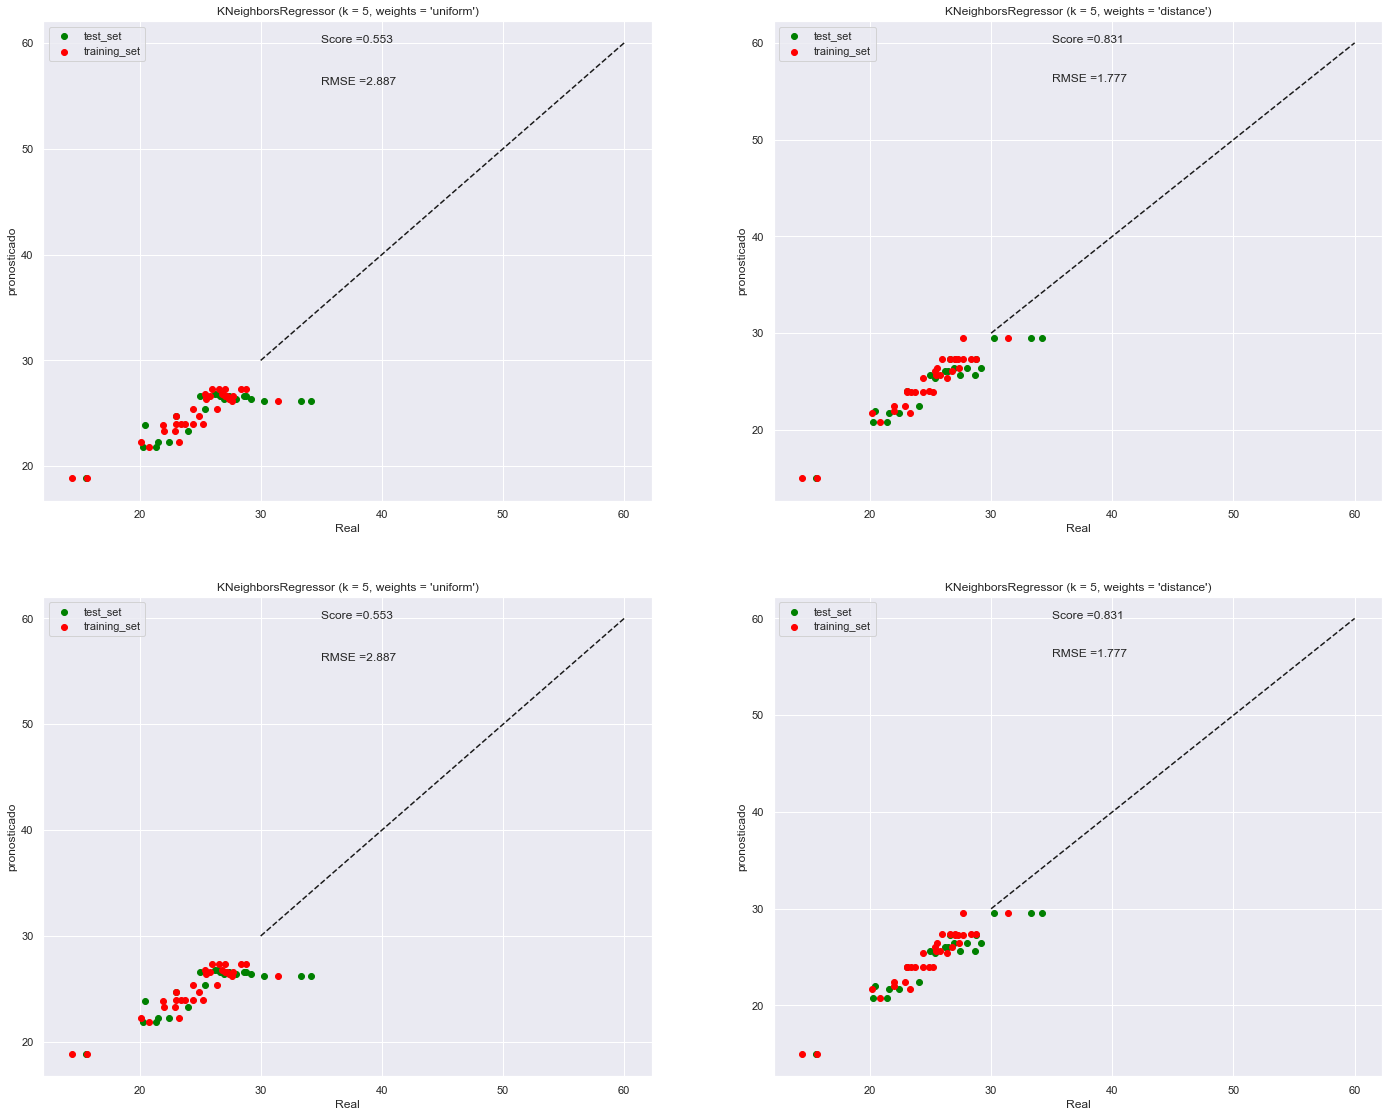

In [34]:
n = features_train.shape[0]
params = [{'weights': 'uniform', 'n_neighbors': 5,"algorithm":"brute"},
          {'weights': 'distance', 'n_neighbors':5,"algorithm":"ball_tree"},
          {'weights': 'uniform', 'n_neighbors': 5,"algorithm":"brute"},
          {'weights': 'distance', 'n_neighbors': 5}]

#plot_range = np.arange(features_train.min(), features_train.max(), 0.01)

for i, param in enumerate(params):
    model = KNeighborsRegressor(**params[i])
    model.fit(features_train, labels_train)

    pred = model.predict(features_test)
    # Sort values for plotting
    plt.subplot(3, 2, i + 1)
    plt.scatter(labels_test,pred, c='green', label='test_set')
    plt.scatter(labels_train,model.predict(features_train), c='red', label='training_set')
    
    score = round(model.score(features_test, labels_test),3)
    rmse = round(np.sqrt(mean_squared_error(labels_test, pred)),3)
    
    
    plt.plot([30,60],[30,60],color="k",linestyle='--')
    
    plt.annotate("Score ="+str(score), (35,59), xytext = (35, 59 + 1), 
                  horizontalalignment='left')
    plt.annotate("RMSE ="+str(rmse), (35,55), xytext = (35, 55 + 1), 
                  horizontalalignment='left')
    
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (params[i]['n_neighbors'], params[i]['weights']))
    plt.ylabel('pronosticado')
    plt.xlabel('Real')

plt.rcParams["figure.figsize"] = [24, 30]
    
plt.show()

In [35]:
model_reg = KNeighborsRegressor(weights='distance',n_neighbors=3)
model_reg.fit(features_train, labels_train)
pred = model_reg.predict(features_test)

## Aplicamos el modelo:

## Aplicamos el modelo:

In [36]:
df_centroides = pd.read_csv("/Users/danielbustillos/Documents/CONACyT/Marginación_contaminación/interpolacion_contaminacion/centroides.csv")
df_centroides.rename(columns={'Y': 'Latitud', 'X': 'Longitud'}, inplace=True)
df_centroides = df_centroides[["Longitud","Latitud"]]

In [37]:
df_centroides.head()

,Longitud,Latitud
0,-99.000422,19.129829
1,-99.013634,19.135934
2,-99.040297,19.137556
3,-99.029781,19.139261
4,-98.998470,19.139254


In [38]:
df_centroides["PM2.5_anual_forecast"] = model_reg.predict(df_centroides[["Longitud","Latitud"]])

In [39]:
df_centroides.head()

,Longitud,Latitud,PM2.5_anual_forecast
0,-99.000422,19.129829,23.142366
1,-99.013634,19.135934,23.159083
2,-99.040297,19.137556,22.362836
3,-99.029781,19.139261,22.334371
4,-98.998470,19.139254,22.992297


In [40]:
df_centroides.to_csv("./contaminación_por_ageb_PM2.5.csv",index=False)